## TFIDF First Simple Model
Logistic Regression out of the box, n-grams=1

In [8]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import re
from src import *
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = load_text(sentences=True, grammarize=True)
df.head()

,Text,Grade
0,I had just gone to + chobot + space and + scie...,1.0
1,+ when I got there I didnt even know one plan...,1.0
2,+ soon I learned all eight planets in our sol...,1.0
3,I learned what the first rocket ship looked l...,1.0
4,I learned how to land a rocket ship,1.0


In [21]:
def assess_model(model, scores, X_train, y_train, ngram_range=(1,3)):
    for ngram in range(ngram_range[0],ngram_range[1]+1):
        lr_count_pipe = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,ngram))),
                                  ('logreg', model)])
        lr_tfidf_pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,ngram))),
                              ('logreg', model)])
        tfidf_scores = cross_val_score(lr_tfidf_pipe, X_train, y_train, cv=3, 
                                         scoring='neg_mean_absolute_error')
        
        count_scores = cross_val_score(lr_count_pipe, X_train, y_train, cv=3, 
                                         scoring='neg_mean_absolute_error')
        scores = scores.append({'model':type(model).__name__,
                        'encoding':'Count Vectors',
                        'ngram':ngram,
                       'score':-np.mean(count_scores)},
                      ignore_index=True)

        scores = scores.append({'model':type(model).__name__,
                        'encoding':'TF-IDF Vectors',
                        'ngram':ngram,
                      'score':-np.mean(tfidf_scores)},
                      ignore_index=True)
        print('finished ngram', ngram)
        
    return scores
                 

In [26]:
X = df.Text
y = df.Grade
## Split lemma train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=11)
scores = pd.DataFrame(columns = ['model','ngram','encoding'])

In [23]:
scores = assess_model(LinearRegression(), scores, X_train, y_train, ngram_range=(1,3))

finished ngram 1
finished ngram 2
finished ngram 3


In [27]:
scores = assess_model(DecisionTreeRegressor(), scores, X_train, y_train, ngram_range=(1,3))

finished ngram 1
finished ngram 2
finished ngram 3


In [28]:
scores = assess_model(RandomForestRegressor(), scores, X_train, y_train, ngram_range=(1,3))

finished ngram 1
finished ngram 2
finished ngram 3


In [29]:
scores.sort_values(by=['score'])

,model,ngram,encoding,score
6,RandomForestRegressor,1,Count Vectors,2.099235
8,RandomForestRegressor,2,Count Vectors,2.103188
10,RandomForestRegressor,3,Count Vectors,2.112516
7,RandomForestRegressor,1,TF-IDF Vectors,2.120977
9,RandomForestRegressor,2,TF-IDF Vectors,2.201663
11,RandomForestRegressor,3,TF-IDF Vectors,2.258665
2,DecisionTreeRegressor,2,Count Vectors,2.484527
4,DecisionTreeRegressor,3,Count Vectors,2.502129
0,DecisionTreeRegressor,1,Count Vectors,2.514203
1,DecisionTreeRegressor,1,TF-IDF Vectors,2.555364


MAE =  2.042295417803922


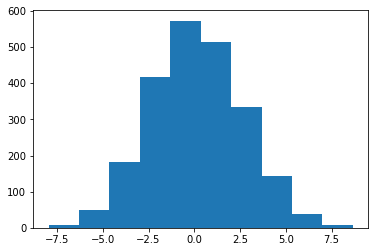

In [30]:
model = RandomForestRegressor()
rf_count_pipe = Pipeline([('vectorizer', CountVectorizer()),
                      ('RFreg', model)])
rf_count_pipe.fit(X_train, y_train)
yhat = rf_count_pipe.predict(X_test)
print('MAE = ', np.sum(np.abs(y_test - yhat))/len(y_test))
plt.hist(yhat - y_test)
plt.show()

In [32]:
rf_count_pipe = Pipeline([('vectorizer', CountVectorizer()),
                      ('RFreg', model)])
param_grid = [{'RFreg__n_estimators':[100,200,300,400, 500, 1000],
              'RFreg__max_depth':[4,6,None],
              }]
clf = GridSearchCV(rf_count_pipe,
                  param_grid, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

-2.060930371143514
{'RFreg__max_depth': None, 'RFreg__n_estimators': 1000}


In [33]:
model = clf.best_estimator_
yhat = model.predict(X_test)
print('mae = ', np.sum(np.abs(y_test - yhat))/len(y_test))

mae =  2.0405086610998855


In [98]:
# import pickle
# pickle.dump(model, open('best_model.pkl','wb'))

In [128]:
model = pickle.load(open('best_model.pkl','rb'))
model.predict([df.grammarized[45]])

array([4.128])

In [129]:
df.Grade[45]

4.0